# Backend (please ignore)

In [666]:
import numpy as np
import pandas as pd
from scipy import stats
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pyreadstat
import researchpy as rp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [667]:
def paired_ttest_1d(df, pairs, alpha= 0.05, violinplot= True):
    # 1. Returns the results of paired t_tests for the 2 dependent samples (mean) for multiple pairs of variables
    # 2. Returns a violin plot at the end to illustrate the difference of samples for each pair of variables    
    #
    # Parameter pairs (dataframe): contains column names (str) of the dependent variables in df to be tested
    # Precondition: pairs contains only 2 columns: 'before' and 'after'; 
    #               for each index, pair.before and pair.after are the names of each pair of dependent variables
    
    for c in range(0, len(pairs.before)):
        before= pairs.iloc[c].before
        after= pairs.iloc[c].after
        paired_ttest_helper(df, before, after, alpha= alpha, violinplot= violinplot)
        #if c < len(pairs.before)-1:
        #    print('\n')

In [668]:
def paired_ttest_helper(df, before, after, alpha= 0.05, violinplot= True): 
    # Returns the results of paired t_tests for the two dependent samples (mean of variable)
    #
    # Precondition: before (str) and after (str) are column names in df (dataframe) and have the same shape
    # Precondition: alpha (float) > 0 and < 1; default = 0.05

    t_stat, p_value= stats.ttest_rel(df[before], df[after])
    
    # Print results
    if p_value > alpha:
        print('%s vs. %s (N = %i): no difference (fail to reject H0)' % (before, after, df[before].count()))
    else:
        print('%s vs. %s (N = %i): the difference is statistically significant (reject H0)' % (before, after, df[before].count()))
                    
    print('mean of %s: %.3f' % (before, df[before].mean()))             
    print('mean of %s: %.3f' % (after, df[after].mean()))    
    print('p-value of the difference: %.3f' % p_value)
    
    # Plot the graphs
    if violinplot == True:
        data = df.melt(value_vars= [before, after])      
        plt.subplot()
        sns.violinplot(x= 'variable', y= 'value', data= data)
        plt.show()
    if violinplot == False:
        data = df.melt(value_vars= [before, after])      
        plt.subplot()
        sns.boxplot(x= 'variable', y= 'value', data= data)
        plt.show()
    if violinplot == None:
        print('\n')

In [669]:
def multi_ttest_2d(df, segment, array_variable, alpha= 0.05, violinplot= True):
    for c in range(0, len(array_variable)):
        multi_ttest_1d(df, segment, array_variable[c], alpha= alpha, violinplot= violinplot)

In [670]:
def multi_ttest_1d(df, segment, variable, alpha= 0.05, violinplot= True):
    # 1. Returns the results of t_tests for the independent samples (mean): 
    #    segment is the independent (grouping) variable and variable contains dependent (test) variables
    # 2. Returns a violin plot at the end to illustrate the difference of samples in each segment
    #
    # Parameter df: the dataframe to be analyzed
    # Precondition: df is a dataframe
    #
    # Parameter segment: a column name (string) of segments from df
    # Precondition: segment is in df; segment is non-metric; data in segment starts from 0 and contains only integers;
    #               the maximum value of segment > 0 (i.e., there are more than 1 segments in df)
    #
    # Parameter variable: a column name (string) of test variable from df
    # Precondition: variable is in df; variable is metric
    #
    # Parameter alpha: decision rule to reject the null hypothesis (default= 0.05)
    # Precondition: alpha is a float > 0 and < 1
    #
    # Parameter violinplot: a boolean indicating whether the function return a violinplot. 
    #                       If violinplot == False, the function returns a boxplot
    # Precondition: violinplot is a boolean, default= True

    seg_min= df[segment].min()
    seg_max= df[segment].max()
    
    for a in range(seg_min, seg_max):
        for b in range(a+1, seg_max+1):
            ttest_helper(df, segment, a, b, variable, alpha)
            if (a < seg_max-1) or (b < seg_max):
                print('\n')

    if violinplot == True:
        plt.subplot()
        sns.violinplot(x= segment, y= variable, data= df)
        plt.show()
    if violinplot == False:
        plt.subplot()
        sns.boxplot(x= segment, y= variable, data= df)
        plt.show()

In [671]:
def ttest_helper(df, segment, a, b, variable, alpha= 0.05): 
    # Returns the results of t_tests for the independent samples (mean of variable) 
    # between segment == a and segment == b
    #
    # Parameter df: the dataframe to be analyzed
    # Precondition: df is a dataframe
    #
    # Parameter segment: a column name (string) of segments from df
    # Precondition: segment is in df; segment is non-metric; data in segment starts from 0 and contains only integers;
    #               the maximum value of segment > 0 (i.e., there are more than 1 segments in df)
    #
    # Parameter a: an integer in segment
    # Precondition: a != b
    #
    # Parameter b: an integer in segment
    # Precondition: b != a
    #
    # Parameter variable: a column name (string) of test variable from df
    # Precondition: variable is in df; variable is metric
    #
    # Parameter alpha: decision rule to reject the null hypothesis (default = 0.05)
    # Precondition: alpha is a float > 0 and < 1
    
    seg_a= df[variable].loc[df[segment] == a]
    seg_b= df[variable].loc[df[segment] == b]
    t_stat, p_value= stats.ttest_ind(seg_a, seg_b)
        
    if p_value > alpha:
        print('In %s, segments %i vs. %i: no difference (fail to reject H0)' % (variable, a, b))
    else:
        print('In %s, segments %i vs. %i: the difference is statistically significant (reject H0)' % (variable, a, b))
                    
    print('mean of %s when (%s = %i): %.3f, N: %i' % (variable, segment, a, seg_a.mean(), seg_a.count()))             
    print('mean of %s when (%s = %i): %.3f, N: %i' % (variable, segment, b, seg_b.mean(), seg_b.count()))    
    print('p-value of the difference: %.3f' % p_value)

In [672]:
def fa_adequacy_test(df):
    # 1. Return a boolean and a detail (str or int), indicating whether the dataframe df is adequate for factor analysis, 
    #    using Bartlett’s Test (with alpha <= 0.05) and Kaiser-Meyer-Olkin test (with KMO > 0.6), 
    #    i.e. "Can we find factors from the observed variables (the columns in the df)?"
    # 2. The detail constains a suggested number of factors if df passes the test, using the Kaiser criterion.
    # 3. The detail contains reasons if df does not pass the test.
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    
    error_msg= ''
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
    chi_square_value, p_value_bs= calculate_bartlett_sphericity(df)
    if p_value_bs > 0.05:
        error_msg= 'df does not pass Bartlett’s test (p-value > 0.05)'
        return False, error_msg
    
    from factor_analyzer.factor_analyzer import calculate_kmo
    kmo_all, kmo_model= calculate_kmo(df)
    if kmo_model < 0.6:
        error_msg= 'df does not pass Kaiser-Meyer-Olkin test (KMO < 0.6)'
        return False, error_msg
    
    n_factors= num_of_factors(df)
    return True, n_factors

In [673]:
def num_of_factors(df, scree_plot= False, eigenvalue= False):
    # Returns a suggested number of factors using Kaiser criterion (min # of factors whose eigenvalue > 1)
    # and an optional scree plot
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    #
    # Parameter scree_plot: a boolean indicating whether the returned values include a scree plot
    # Precondition: a boolean, default = False (no plot)
    #
    # Parameter eigenvalue: a boolean indicating whether the returned values include an array of eigenvalues
    # Precondition: a boolean, default = False (no eigenvalues returned)
    
    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer(n_factors= df.shape[1], rotation= None)    
    fa.fit(df)

    ev, v = fa.get_eigenvalues()    
    num_of_factor= 0
    for a in range(0, len(ev)):
        if ev[a] > 1:
            num_of_factor+= 1

    if scree_plot == False:
        if eigenvalue == False:
            return num_of_factor
        if eigenvalue == True:
            return num_factor, ev
    if scree_plot == True:
        plt.scatter(range(1, df.shape[1]+1), ev)
        plt.plot(range(1, df.shape[1]+1), ev)
        plt.title('Scree Plot')
        plt.xlabel('Factors')
        plt.ylabel('Eigenvalue')
        plt.grid()
        plt.show() 
        if eigenvalue == False:
            return num_of_factor
        if eigenvalue == True:    
            return num_of_factor, ev

In [674]:
def factor_analysis(df, name= None):
    # Returns the factor variance info of factor analysis (rotation= 'varimax') of df and transformed df, 
    # if df passes the adequecy test
    # Returns the reason if df does not pass the adequecy test
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    #
    # Parameter name (str): pre-fix to be added before "Factor" naming
    
    
    result, detail= fa_adequacy_test(df)
    if result == True:
        fa= FactorAnalyzer(n_factors= detail, rotation= 'varimax', method= 'principal') 
        fa.fit(df)
        
        if name == None:
            factor_col_names= ['factor' + str(i+1) for i in range(0, detail)]
        else:
            factor_col_names= [name + '_factor' + str(i+1) for i in range(0, detail)]
        tranform= fa.transform(df)      
        transform_df= pd.DataFrame(data= tranform[0:,0:],
                                   index= [i for i in range(tranform.shape[0])],
                                   columns= factor_col_names)
        loadings= pd.DataFrame(data= fa.loadings_, index= df.columns, columns= factor_col_names)
        return fa.get_factor_variance(), loadings, transform_df
    else:
        return detail, 'N/A'

In [675]:
def elbow_KMean(data):
    # Returns a plot of number of clusters of KMean vs. the sum of squared distances for elbow method
    #
    # Parameter df: the dataframe to be classified using KMean
    # Precondition: df is a dataframe
    
    Sum_of_squared_distances = []
    k_clusters = np.arange(1, 11)
    for k in k_clusters:
        km_models = KMeans(k).fit(data)
        Sum_of_squared_distances.append(km_models.inertia_)

    plt.scatter(k_clusters, Sum_of_squared_distances)
    plt.plot(k_clusters, Sum_of_squared_distances)
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.grid()
    plt.show() 

In [676]:
def cluster_analysis(df, n_cluster, name= None, label= True):
    # Returns a dataframe of df with a new column 'Segment' + str(n_cluster) with labels from KMean classification
    #
    # Parameter df: dataframe to be analyzed, with all columns containing metric variables
    #
    # Parameter label: a boolean indicating whether to add a new column indicating the labels 
    #                  from Kmean classification to df
    # Precondition: label is a boolean, default = True
    
    data= df.copy()
    kmeans= KMeans(n_clusters= n_cluster)
    kmeans.fit(data)
    
    if label == True:
        if name == None:
            n_segment= 'segment' + str(n_cluster)
        else:
            n_segment= name + '_segment' + str(n_cluster)
        data[n_segment]= kmeans.labels_
        
    return data

In [677]:
def GMM(df, n_cluster, name= None, label= True):
    # Returns a dataframe of df with a new column 'Segment' + str(n_cluster) with labels from GMM classification
    #
    # Parameter df: dataframe to be analyzed, with all columns containing metric variables
    #
    # Parameter label: a boolean indicating whether to add a new column indicating the labels 
    #                  from Kmean classification to df
    # Precondition: label is a boolean, default = True   
    
    data= df.copy()
    gmm= GaussianMixture(n_components= n_cluster)
    labels= gmm.fit(df).predict(df)

    if label == True:
        if name == None:
            n_segment= 'segment' + str(n_cluster)
        else:
            n_segment= name + '_segment' + str(n_cluster)
        data[n_segment]= labels
        
    return data   
    
    
    #labels = gmm.predict(X_std)

In [678]:
def regression(predictors, ind_var, data):
    # Returns the regression model of X, Y, the beta of the regression model, and the VIF
    #
    # Parameter x (list of str): column names of preditors
    # Predonfition: x in data
    #
    # Parameter y (str): column name of the dependent variable
    # Precondition: y in data
    #
    # Parameter data (dataframe): data source for x and y
    
    # Regression model
    X = sm.add_constant(data[x])
    Y = data[y]
    OLS_model = sm.OLS(Y,X)
    result = OLS_model.fit()
    #print(result.summary())
    
    # Beta (standardized coefficient)
    std= OLS_model.exog.std(axis= 0)    # standardize each column of exog (the predictors), ps. endog is Y
    std_y= Y.values.std()
    tt= result.t_test(np.diag(std/std_y)[1:])    # ignore the constant
    #print(tt.summary(xname= variables, title= 'Standardized Coefficient (beta)'))    # Prints an OLS summary
    beta= tt.summary_frame(xname= x).round(3)    # Returns a dataframe
    
    # VIF
    vif= pd.DataFrame()
    vif["Features"]= X.columns
    vif["VIF Factor"]= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif= vif.drop(0)
    
    return result, beta, VIF

In [679]:
def corr_hmap(df, figsize= (20, 12), cbar_shrink= 0.5):
    # Plots a correlation heat map of df
    #
    # Precondition: cbar_shrink (int) between 0 and 1
    
    corr= df.corr()

    sns.set(style= 'white', rc= {'figure.figsize': figsize})
    mask= np.triu(corr)
    ax_corr= sns.heatmap(corr, annot= True, fmt= '.3f', mask= mask, vmin= -1, vmax= 1, center= 0, 
                         cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": cbar_shrink})
    ax_corr.tick_params(axis ='y', rotation = 0)
    plt.show()
    sns.reset_orig()

In [680]:
def loading_hmap(loadings, figsize= (4,10), cbar_shrink= 0.5):
    # Plots a heat map of the loadings from factor analysis
    
    sns.set(style= 'white', rc= {'figure.figsize': figsize})
    loadings_min= loadings.min().min()
    loadings_max= loadings.max().max()
    loadings_mid= (loadings_min + loadings_max) / 2
    ax_loadings= sns.heatmap(loadings, annot= True, fmt= '.3f', vmin= loadings_min, vmax= loadings_max, 
                             center= loadings_mid, cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": cbar_shrink})
    ax_loadings.xaxis.set_ticks_position('top')
    ax_loadings.tick_params(axis ='y', rotation = 0)
    plt.show()
    sns.reset_orig()

In [681]:
def groupby_hmap(groupby, figsize= (6, 3)):
    # Plots a heat map of the result of groupby_pct feature
    
    sns.set(style= 'white', rc= {'figure.figsize': figsize}, font_scale=1.2)
    groupby_min= groupby.min().min()
    groupby_max= groupby.max().max()
    groupby_mid= (groupby_min + groupby_max) / 2
    pal= sns.color_palette(sns.cubehelix_palette(20, start=.5, rot=-.75))
    ax_groupby= sns.heatmap(groupby, annot= True, fmt= '.1f', vmin= groupby_min, vmax= groupby_max, 
                            center= groupby_mid, cmap= pal, linewidths= .5, cbar= False, annot_kws= {'size': 13})
    ax_groupby.xaxis.set_ticks_position('top')
    ax_groupby.tick_params(axis ='y', rotation = 0)
    plt.show()
    sns.reset_orig()

In [682]:
def groupby_pct(df, segment= None, single_choice= False, heatmap= True, figsize= (6,1)):
    # Returns a df or a heatmap of the crosstab of percentage within each segment
    # Segment= None for no segment analysis
    # Precondition: All columns in df (dataframe) are categorical variables and segment is not in df
    # Precondition: segment (array-like) has the same length as df.shape[0]; heatmap (bool); single_choice (bool)       
    
    if segment is None:
        if single_choice is False:
            proportion= df.sum()/df.shape[0]*100
        else:
            proportion= df.value_counts(sort= False)/df.count()*100
        data= pd.DataFrame({'Proportion (%)': proportion.values}, index= proportion.index.values,).T        
    else:
        if single_choice is False:
            def pct(x):
                return x.sum()/x.count()*100
            #pct_str.__name__ = 'pct'
            data= df.groupby(segment).agg(pct)
        else:
            data= pd.crosstab(segment, df)
            data= data.div(data.sum(axis= 1), axis= 0)*100        
    
    if heatmap is False:
        return data
    
    groupby_hmap(data, figsize= figsize)

In [683]:
test= df['immersion']
g= pd.crosstab(Q8_cluster2['Q8_segment2'], test)
f= g.div(g.sum(axis=1), axis = 0)*100
f


immersion,CFI,DTI,IB,IRAM,SGE,SPMI,SSO,cust/no,other
Q8_segment2,,,,,,,,,
0,3.125000,21.875000,3.125000,9.375000,3.125000,28.125000,0.000000,31.250000,0.000000
1,10.810811,13.513514,9.459459,4.054054,2.702703,22.972973,9.459459,24.324324,2.702703


In [684]:
def barplot_1d(df, figsize= (12, 6), seg_num= None):
    # Plots a barplot with all the counts of the variables (columns) in df
    # Parameter seg_num is only for the use of barplot_2d
    
    df_sum= df.sum()
    
    data= pd.DataFrame({
        'Item': df_sum.index.values,
        'Frequency': df_sum.values
    })

    plt.figure(figsize= figsize)
    pal= sns.color_palette('Blues_d', len(data.Item))
    rank= data['Frequency'].argsort().argsort()
    sns.barplot(x= 'Item', y= 'Frequency', data= data, palette= np.array(pal[::-1])[rank])
    
    #def autolabel(rects):
    #    for rect in rects:
    #        height = rect.get_height()
    #        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
    #                '%d' % int(height),
    #                ha='center', va='bottom')
    
    if seg_num != None:
        plt.title('Segment ' + str(seg_num))
    plt.show()

In [685]:
def barplot_2d(df, segment, figsize= (12, 6), pct= False):
    # Plots a barplot with all the counts of the variables in df, separated by segment
    # Precondition segment (array-like) : len(segment) must equal to len(one of df's column)
    
    seg_min= segment.min()
    seg_max= segment.max()
    temp= df.copy()
    temp['segment']= segment
    
    for a in range(seg_min, seg_max+1):
        df['segment']= segment
        
        data= temp.loc[temp['segment'] == a]
        data= data.drop('segment', axis= 1)
        
        if pct == True:
            data= data/data.sum().sum()*100
        
        barplot_1d(data, figsize= figsize, seg_num= a)

# Load and Clean Data

In [686]:
df= pd.DataFrame()
df, meta= pyreadstat.read_sav('SPMI.sav')
if df['Finished'].min() == 1:
    # Remove unnecessary or confidential info
    duration_sec= df['Duration__in_seconds_'].copy()
    df= df.iloc[:, df.columns.get_loc('Q2'):df.columns.get_loc('Q26')+1]
    df['duration_min']= duration_sec/60
    
    # Rename the demographics
    df.replace({'Q2': {1: 'Credit', 2: '$10', 3: 'Love'}, 
                'Q3': {1: '2-year', 2: 'AMBA', 3: 'dual', 4: 'other'},
                'Q4': {1: '2020', 2: '2021', 3: '2022'},
                'Q5': {1: 'CFI', 2: 'DTI', 3: 'IB', 4: 'IRAM', 5: 'SGE', 6: 'SPMI', 
                       7: 'SSO', 8: 'other', 9: 'cust/no'},
                'Q20': {1: 'international', 0: 'domestic', 2: 'dual'},
                'Q21': {1: 'Male', 2: 'Female', 3: 'queer', 4: 't_male', 5: 't_female', 6: 'other', 7: 'n/d'},
                'Q23': {1: 'Consulting', 2: 'Creative', 3: 'Education', 4: 'Engineering', 5: 'Entrepreneurship',
                        6: 'Finance', 7: 'HR', 8: 'IB', 9: 'Legal', 10: 'GM', 11: 'Marketing', 12: 'Operations', 
                        13: 'PE/VC', 14: 'PM', 15: 'Sales', 16: 'other'},
                'Q25': {1: 'Consulting', 2: 'Creative', 3: 'Education', 4: 'Engineering', 5: 'Entrepreneurship',
                        6: 'Finance', 7: 'HR', 8: 'IB', 9: 'Legal', 10: 'GM', 11: 'Marketing', 12: 'Operations', 
                        13: 'PE/VC', 14: 'PM', 15: 'Sales', 16: 'other', 17: 'tbd'}}, inplace= True)
    df= df.rename(columns={'Q2': 'reward', 'Q3': 'program', 'Q4': 'class', 'Q5': 'immersion',
                           'Q7_13': 'Q7', 'Q15_8': 'Q15', 'Q17_8': 'Q17', 'Q20': 'intl', 
                           'Q21': 'gender', 'Q23': 'pre-MBA', 'Q25': 'post-MBA'})    
    
    # Generate a csv file for text response analysis
    df.to_csv('SPMI.csv', index= False)
else:
    print('Someone did not finish the survey.')

# Preliminary Overivew

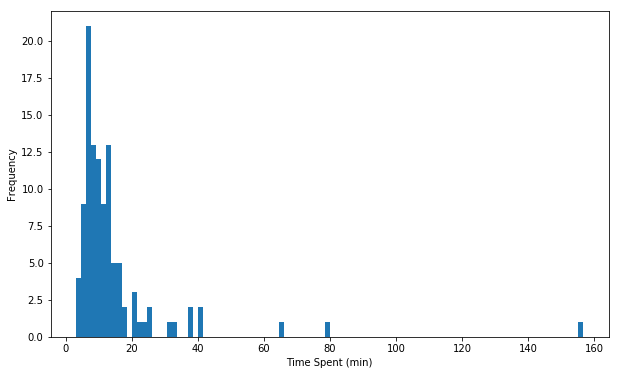

In [687]:
# Check if anyone finished the survey in an unbelievably short amount of time
plt.figure(figsize= (10,6))
plt.hist(df['duration_min'], bins= 100)
plt.xlabel('Time Spent (min)')
plt.ylabel('Frequency')
plt.show()

In [688]:
# Summary of the preliminary demographics
print('Total participants: %i' % df['reward'].count())
print(df['reward'].value_counts())
pd.crosstab([df.program, df['class']], df.immersion, margins= True, margins_name= 'total')

Total participants: 109
$10       87
Credit    22
Name: reward, dtype: int64


immersion      CFI  DTI  IB  IRAM  SGE  SPMI  SSO  cust/no  other  total
program class                                                           
2-year  2020     6   12   5     2    3     9    7        3      0     47
        2021     3    5   3     2    0    15    1        3      0     32
        2022     0    0   0     0    0     0    0        1      0      1
AMBA    2020     0    0   0     2    0     2    0       19      2     25
        2021     0    0   0     0    0     0    0        1      0      1
dual    2021     0    0   0     0    0     1    0        0      0      1
other   2020     0    0   0     0    0     0    0        1      0      1
        2022     0    0   0     0    0     0    0        1      0      1
total            9   17   8     6    3    27    8       29      2    109

In [689]:
# Demographics with international students
print(df['gender'].value_counts())
pd.crosstab([df.program, df['class'], df.intl], df.immersion, margins= True, margins_name= 'total')

Male      56
Female    51
n/d        2
Name: gender, dtype: int64


immersion                    CFI  DTI  IB  IRAM  SGE  SPMI  SSO  cust/no  \
program class intl                                                         
2-year  2020  domestic         4    7   4     2    2     9    5        2   
              international    2    5   1     0    1     0    2        1   
        2021  domestic         2    2   3     1    0    10    1        3   
              dual             1    0   0     0    0     0    0        0   
              international    0    3   0     1    0     5    0        0   
        2022  dual             0    0   0     0    0     0    0        1   
AMBA    2020  domestic         0    0   0     0    0     0    0        5   
              international    0    0   0     2    0     2    0       14   
        2021  domestic         0    0   0     0    0     0    0        1   
dual    2021  domestic         0    0   0     0    0     1    0        0   
other   2020  international    0    0   0     0    0     0    0        1   
        2022  domestic         0    0   0     0    0     0    0        1   
total                          9   17   8     6    3    27    8       29   

immersion                    other  total  
program class intl                         
2-year  2020  domestic           0     35  
              international      0     12  
        2021  domestic           0     22  
              dual               0      1  
              international      0      9  
        2022  dual               0      1  
AMBA    2020  domestic           1      6  
              international      1     19  
        2021  domestic           0      1  
dual    2021  domestic           0      1  
other   2020  international      0      1  
        2022  domestic           0      1  
total                            2    109

In [690]:
pd.crosstab(df['pre-MBA'], df['post-MBA'], margins= True, margins_name= 'total')

post-MBA,Consulting,Creative,Finance,GM,HR,IB,Legal,Marketing,Operations,PE/VC,PM,other,tbd,total
pre-MBA,,,,,,,,,,,,,,
Consulting,10,0,2,0,0,0,0,1,0,1,3,0,0,17
Creative,0,2,0,0,0,0,0,0,0,0,0,0,0,2
Education,1,0,0,0,1,0,0,1,0,0,0,0,0,3
Engineering,2,0,0,1,0,0,0,0,0,0,5,0,0,8
Entrepreneurship,0,0,1,0,0,0,0,0,0,0,0,0,0,1
Finance,5,0,9,1,0,3,0,2,0,1,2,0,1,24
GM,1,0,1,3,0,0,0,2,1,0,1,0,0,9
HR,0,0,0,0,0,1,0,0,0,0,0,0,0,1
Legal,0,0,1,0,0,0,1,0,0,0,1,0,0,3


In [691]:
# Descriptive analysis
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

df.describe().round(2)

,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q7,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,Q8_8,Q8_9,Q8_10,Q8_11,Q9_1,Q9_2,Q9_3,Q9_4,Q9_5,Q9_6,Q9_7,Q9_8,Q9_9,Q9_10,Q9_11,Q10_1,Q10_2,Q10_3,Q10_4,Q10_5,Q10_6,Q10_7,Q10_8,Q10_9,Q10_10,Q10_11,Q10_12,Q10_13,Q10_14,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q14_1,Q14_2,Q15,Q17,duration_min
count,69.0,18.0,21.0,39.0,41.0,20.0,28.0,59.0,15.0,17.0,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,34.0,29.0,34.0,42.0,38.0,13.0,36.0,64.0,15.0,19.0,33.0,13.0,50.0,16.0,24.0,40.0,41.0,18.0,23.0,18.0,25.0,42.0,50.0,44.0,33.0,47.0,57.0,57.0,26.0,109.00,109.00,109.00,109.00,109.00
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.45,5.56,5.30,5.52,5.62,5.42,5.55,5.39,5.07,5.39,5.59,5.00,4.85,4.88,5.16,4.72,4.73,4.78,5.06,5.02,5.09,4.40,3.94,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.63,5.33,5.62,3.46,14.51
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.94,1.24,1.33,1.16,1.07,1.30,1.34,1.22,1.44,1.25,1.23,1.46,1.59,1.53,1.52,1.52,1.49,1.73,1.57,1.58,1.51,1.77,1.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.01,1.09,1.37,2.00,17.72
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.00,1.00,1.00,1.00,1.00,2.00,1.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.00,2.00,1.00,1.00,3.03
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,5.00,5.00,4.00,4.00,4.00,5.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,3.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.00,5.00,5.00,2.00,7.27
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,5.00,5.00,6.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.00,5.00,6.00,3.00,10.18
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,5.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.00,6.00,7.00,5.00,14.33
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.00,7.00,7.00,7.00,156.75


# Aggregated Data Analysis

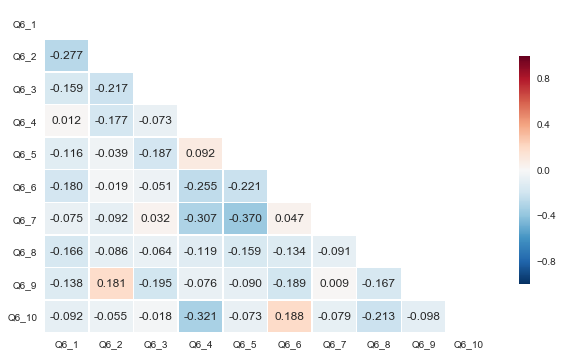

In [692]:
# Correlation of Q6 (MBA goals)
Q6= df.iloc[:, df.columns.get_loc('Q6_1'):df.columns.get_loc('Q6_10')+1].fillna(0)
corr_hmap(Q6, figsize= (10, 6), cbar_shrink= 0.7)

# Low correlation: no need to do a factor analysis

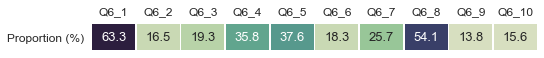

In [693]:
# Q6 (MBA goals) proportion
groupby_pct(Q6, figsize= (8,0.5))

# 64% of the participants selected Q6_1
# 54% of the participants selected Q6_8

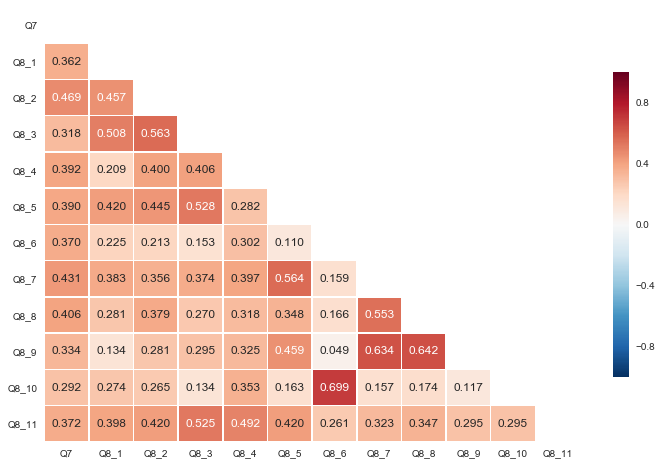

In [694]:
# Correlation of Q7 & Q8 (satisfaction/performance)
Q7Q8= df.iloc[:, df.columns.get_loc('Q7'):df.columns.get_loc('Q8_11')+1]
corr_hmap(Q7Q8, figsize= (12, 8), cbar_shrink= 0.7)

# Fairly correlated, good to go with factor analysis

In [695]:
# Q8 (satisfaction/performance) factor analysis
Q8= df.iloc[:, df.columns.get_loc('Q8_1'):df.columns.get_loc('Q8_11')+1]
factor_variance_Q8, loadings_Q8, transformed_variables_Q8= factor_analysis(Q8, name= 'Q8')
factor_variance_Q8

# 3 factors explaining 67% of the variance

(array([2.88012174, 2.50108825, 1.93265742]),
 array([0.26182925, 0.22737166, 0.17569613]),
 array([0.26182925, 0.48920091, 0.66489704]))

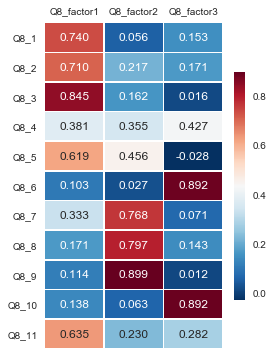

In [696]:
loading_hmap(loadings_Q8, figsize= (4, 6), cbar_shrink= 0.7)

# Factor 1: Q8_1,2,3,5,11 - learning & mental health
# Factor 2: Q8_7,8,9 - recruiting
# Factor 3: Q8_6,10 - social & extracurriculum
# These 3 factors actually form the golden triangle of MBA...lol

In Q7, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q7 when (Q8_segment2 = 0): 4.909, N: 33
mean of Q7 when (Q8_segment2 = 1): 5.684, N: 76
p-value of the difference: 0.000


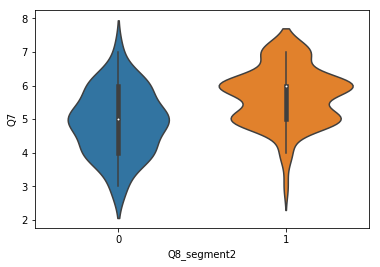

In [697]:
# Q8 (satisfaction/performance) with 2 clusters
Q8_cluster2= cluster_analysis(transformed_variables_Q8, 2, name= 'Q8')
outcome_variables= 'Q7'
Q8_cluster2[outcome_variables]= df[outcome_variables]
multi_ttest_1d(Q8_cluster2, 'Q8_segment2', outcome_variables, alpha= 0.05, violinplot= True)

# 2 clusters passes the t-test on overall satisfaction 

In Q7, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q7 when (Q8_segment3 = 0): 4.952, N: 21
mean of Q7 when (Q8_segment3 = 1): 5.877, N: 57
p-value of the difference: 0.000


In Q7, segments 0 vs. 2: no difference (fail to reject H0)
mean of Q7 when (Q8_segment3 = 0): 4.952, N: 21
mean of Q7 when (Q8_segment3 = 2): 5.000, N: 31
p-value of the difference: 0.853


In Q7, segments 1 vs. 2: the difference is statistically significant (reject H0)
mean of Q7 when (Q8_segment3 = 1): 5.877, N: 57
mean of Q7 when (Q8_segment3 = 2): 5.000, N: 31
p-value of the difference: 0.000


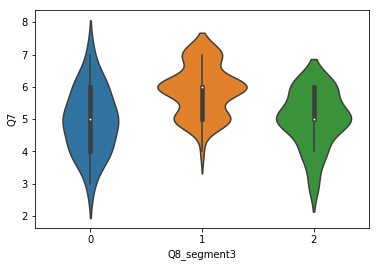

In [698]:
# Q8 (satisfaction/performance) with 3 clusters
Q8_cluster3= cluster_analysis(transformed_variables_Q8, 3, name= 'Q8')
Q8_cluster3[outcome_variables]= df[outcome_variables]
multi_ttest_1d(Q8_cluster3, 'Q8_segment3', outcome_variables, alpha= 0.05, violinplot= True)

# 3 clusters do not pass the t-test on overall satisfaction

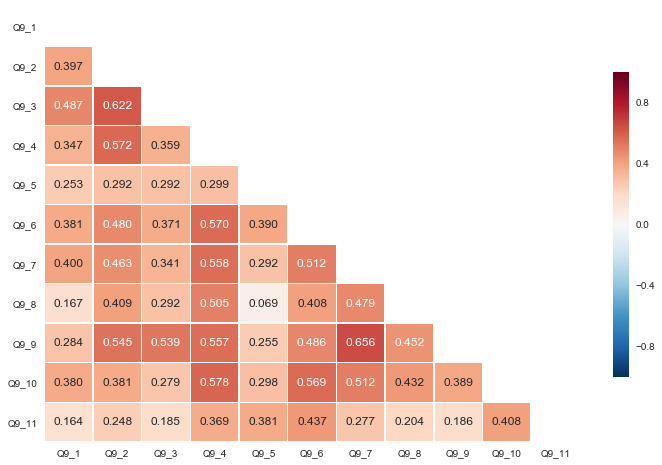

In [699]:
# Correlation of Q9 (help needed/importance)
Q9= df.iloc[:, df.columns.get_loc('Q9_1'):df.columns.get_loc('Q9_11')+1]
corr_hmap(Q9, figsize= (12, 8), cbar_shrink= 0.7)

# Fairly correlated: good to go with factor analysis

In [700]:
# Q9 (help needed/importance) factor analysis
factor_variance_Q9, loadings_Q9, transformed_variables_Q9= factor_analysis(Q9, name= 'Q9')
factor_variance_Q9

# 3 factors explaining 65.8% of the variance

(array([3.06423625, 2.28508877, 1.92204107]),
 array([0.27856693, 0.20773534, 0.17473101]),
 array([0.27856693, 0.48630227, 0.66103328]))

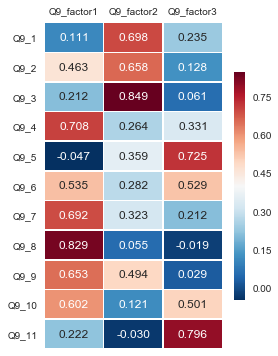

In [701]:
loading_hmap(loadings_Q9, figsize= (4, 6), cbar_shrink= 0.7)

# The loading matrix is a bit rough here, as there is no strong distinction
# There are several correlation coefficients at around 0.4~0.5 across more than 1 factors

In [702]:
# Q9 Q9 (help needed/importance) with 2 clusters
Q9_cluster2= cluster_analysis(transformed_variables_Q9, 2, name= 'Q9')
Q9_cluster2[outcome_variables]= df[outcome_variables]
multi_ttest_1d(Q9_cluster2, 'Q9_segment2', outcome_variables, alpha= 0.05, violinplot= None)

# 2 clusters fail to pass the t-test on overall satisfaction

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (Q9_segment2 = 0): 5.485, N: 68
mean of Q7 when (Q9_segment2 = 1): 5.390, N: 41
p-value of the difference: 0.610


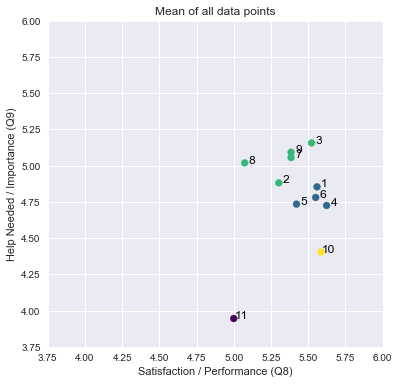

In [703]:
# Plot performance (Q8) vs. importance (Q9) for 11 items
Q8Q9= pd.DataFrame({
    'Q8': Q8.mean().values, 
    'Q9': Q9.mean().values,
})
Q8Q9= cluster_analysis(Q8Q9, 4)
#Q8Q9= GMM(Q8Q9, 3)

Q8Q9['item']= np.arange(1,12)

sns.set()
plt.figure(figsize=(6, 6))
plt.scatter(x= 'Q8', y= 'Q9', data= Q8Q9, c= 'segment4', cmap='viridis')
plt.xlim((3.75, 6))  
plt.ylim((3.75, 6))  
#plt.xlim((4.25, 5.8))  
#plt.ylim((4.25, 5.8)) 
plt.xlabel('Satisfaction / Performance (Q8)')
plt.ylabel('Help Needed / Importance (Q9)')
plt.title('Mean of all data points')

for point in range(0, Q8Q9.shape[0]):
     plt.text(Q8Q9.Q8[point]+0.05, Q8Q9.Q9[point], Q8Q9.item[point], 
              horizontalalignment='center', size='medium', color='black')
plt.show()
sns.reset_orig()

# The number of clusters is just a judgement call
# It seems that item 8 have relatively low satisfaction but high importance

Q8_1 vs. Q9_1 (N = 109): the difference is statistically significant (reject H0)
mean of Q8_1: 5.560
mean of Q9_1: 4.853
p-value of the difference: 0.001


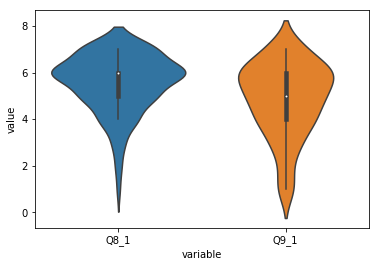

Q8_2 vs. Q9_2 (N = 109): the difference is statistically significant (reject H0)
mean of Q8_2: 5.303
mean of Q9_2: 4.881
p-value of the difference: 0.040


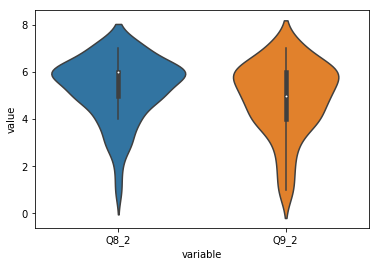

Q8_3 vs. Q9_3 (N = 109): no difference (fail to reject H0)
mean of Q8_3: 5.523
mean of Q9_3: 5.156
p-value of the difference: 0.059


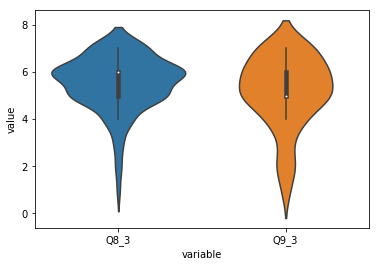

Q8_4 vs. Q9_4 (N = 109): the difference is statistically significant (reject H0)
mean of Q8_4: 5.624
mean of Q9_4: 4.725
p-value of the difference: 0.000


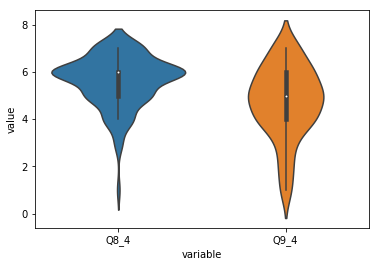

Q8_5 vs. Q9_5 (N = 109): the difference is statistically significant (reject H0)
mean of Q8_5: 5.422
mean of Q9_5: 4.734
p-value of the difference: 0.001


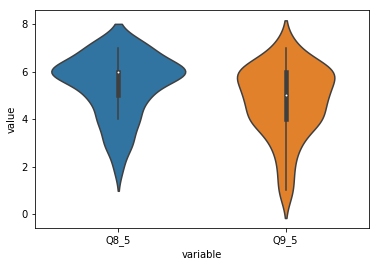

Q8_6 vs. Q9_6 (N = 109): the difference is statistically significant (reject H0)
mean of Q8_6: 5.550
mean of Q9_6: 4.780
p-value of the difference: 0.001


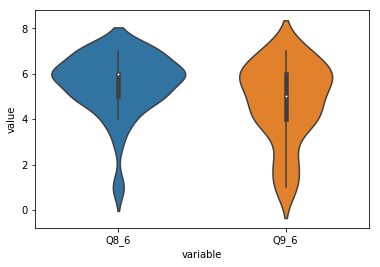

Q8_7 vs. Q9_7 (N = 109): no difference (fail to reject H0)
mean of Q8_7: 5.385
mean of Q9_7: 5.055
p-value of the difference: 0.100


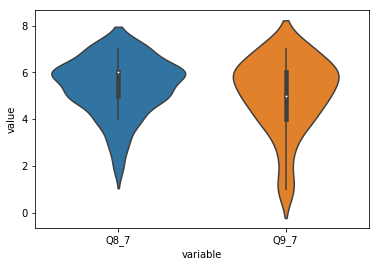

Q8_8 vs. Q9_8 (N = 109): no difference (fail to reject H0)
mean of Q8_8: 5.073
mean of Q9_8: 5.018
p-value of the difference: 0.802


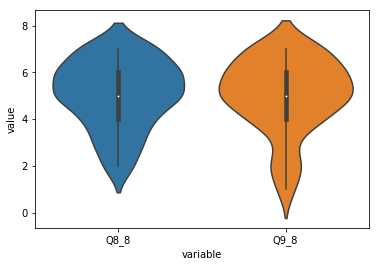

Q8_9 vs. Q9_9 (N = 109): no difference (fail to reject H0)
mean of Q8_9: 5.385
mean of Q9_9: 5.092
p-value of the difference: 0.166


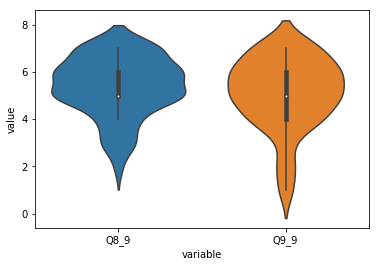

Q8_10 vs. Q9_10 (N = 109): the difference is statistically significant (reject H0)
mean of Q8_10: 5.587
mean of Q9_10: 4.404
p-value of the difference: 0.000


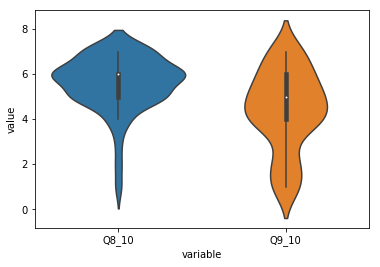

Q8_11 vs. Q9_11 (N = 109): the difference is statistically significant (reject H0)
mean of Q8_11: 5.000
mean of Q9_11: 3.945
p-value of the difference: 0.000


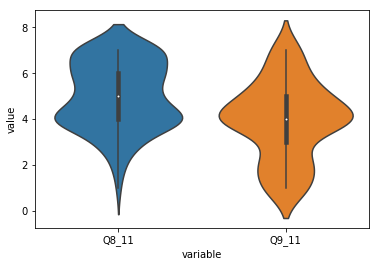

In [704]:
# Pair t-tests for satisfaction (Q8) and importance (Q9)
pairs_all= pd.DataFrame({
    'before': Q8.columns.values,
    'after': Q9.columns.values
})

pairs= pd.DataFrame({
    'before': ['Q8_2', 'Q8_8', 'Q8_1', 'Q8_4', 'Q8_5', 'Q8_10'],
    'after': ['Q9_2', 'Q9_8', 'Q9_1', 'Q9_4', 'Q9_5', 'Q9_10']
})

paired_ttest_1d(df, pairs_all, alpha= 0.05, violinplot= True)

# However, item 2 & 8 do not pass the paired t-test
# i.e., the difference between the mean of Q8_8 and Q9_8 are NOT statistically significant, and same for item 2

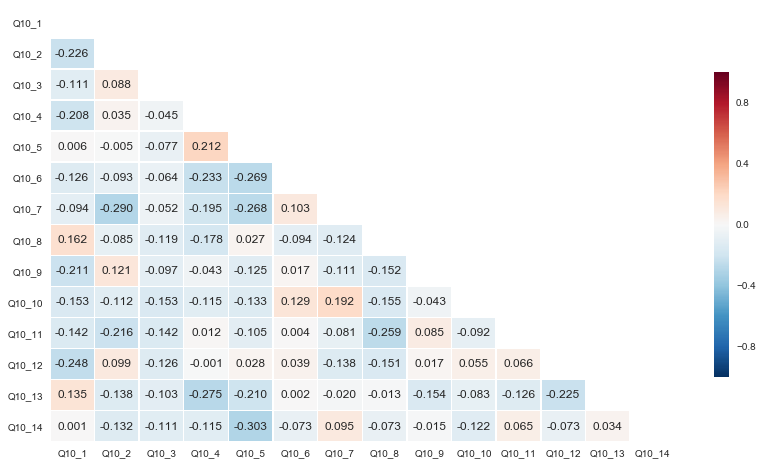

In [705]:
# Correlation of Q10 (solutions)
Q10= df.iloc[:, df.columns.get_loc('Q10_1'):df.columns.get_loc('Q10_14')+1].fillna(0)
corr_hmap(Q10, figsize= (14, 8), cbar_shrink= 0.7)

# Low correlation: no need for factor analysis

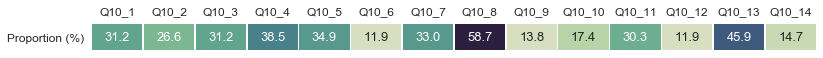

In [706]:
# Q10 (solutions) proportion
groupby_pct(Q10, figsize= (13,0.5))

# 60% of the participants selected Q10_8
# 45% of the participants selected Q10_13

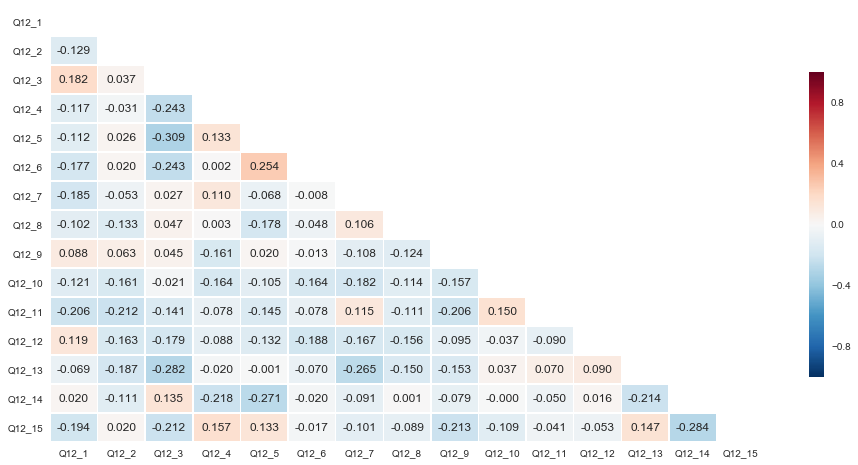

In [707]:
# Correlation of Q12 (product specific)
Q12= df.iloc[:, df.columns.get_loc('Q12_1'):df.columns.get_loc('Q12_15')+1].fillna(0)
corr_hmap(Q12, figsize= (16, 8), cbar_shrink= 0.7)

# Low correlation: no need for factor analysis

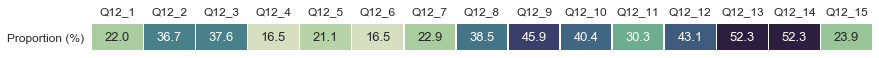

In [708]:
# Q12 (product specific) proportion
groupby_pct(Q12, figsize= (14,0.5))

# 53% of the participants selected Q12_13
# 53% of the participants selected Q12_13

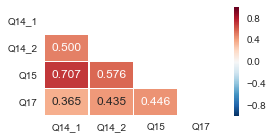

In [709]:
# Correlation of Q14-17 (product specific)
Q1417= df.iloc[:, df.columns.get_loc('Q14_1'):df.columns.get_loc('Q17')+1].fillna(0)
corr_hmap(Q1417, figsize= (4, 2), cbar_shrink= 1)

# Relevance is correlated with usage likelihood, but not so much with likelihood to pay

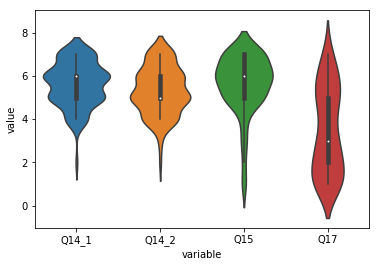

In [710]:
# Q14-17 (product specific) overview
sns.violinplot(x= 'variable', y= 'value', data= pd.melt(Q1417))
plt.show()

# Profiling Analysis (Q8_segment2)

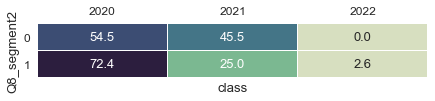

In [714]:
# Demographics of Q8_segment2
demographic= 'class'

groupby_pct(df[demographic], segment= Q8_cluster2['Q8_segment2'], single_choice= True, figsize= (7,1))

# Class 2020 more satisfied?

In [715]:
# Q8 factors by segment 0 & 1
Q8_cluster2[['Q8_factor1', 'Q8_factor2', 'Q8_factor3']].groupby(
    Q8_cluster2['Q8_segment2']).agg(['mean', 'std', 'count']).round(3)

# Factor 1: Q8_1,2,3,5,11 - learning & mental health
# Factor 2: Q8_7,8,9 - recruiting
# Factor 3: Q8_6,10 - social

Q8_factor1              Q8_factor2              Q8_factor3         \
                  mean    std count       mean    std count       mean    std   
Q8_segment2                                                                     
0               -0.279  1.118    33     -1.210  0.701    33     -0.260  1.247   
1                0.121  0.933    76      0.525  0.565    76      0.113  0.864   

                   
            count  
Q8_segment2        
0              33  
1              76

In [716]:
# Q9 by segment 0 & 1
Q9.groupby(Q8_cluster2['Q8_segment2']).agg(['mean', 'std']).round(2)

Q9_1        Q9_2        Q9_3        Q9_4        Q9_5        Q9_6  \
             mean   std  mean   std  mean   std  mean   std  mean   std  mean   
Q8_segment2                                                                     
0            4.73  1.35  4.91  1.40  5.12  1.49  4.79  1.22  4.55  1.18  4.88   
1            4.91  1.69  4.87  1.59  5.17  1.54  4.70  1.64  4.82  1.61  4.74   

                   Q9_7        Q9_8        Q9_9       Q9_10       Q9_11        
              std  mean   std  mean   std  mean   std  mean   std  mean   std  
Q8_segment2                                                                    
0            1.39  5.27  1.23  5.24  1.25  5.45  1.03  4.58  1.30  3.85  1.48  
1            1.87  4.96  1.69  4.92  1.70  4.93  1.65  4.33  1.94  3.99  1.75

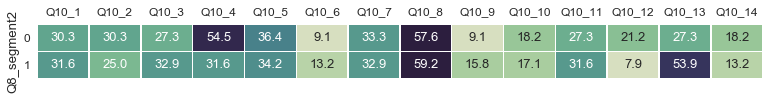

In [717]:
# Q10 proportion by segments
groupby_pct(Q10, segment= Q8_cluster2['Q8_segment2'], figsize= (13,1))

# 59% of segment 0 selected Q10_8
# 53% of segment 0 selected Q10_4

# 60% of segment 1 selected Q10_8
# 53% of segment 1 selected Q10_13

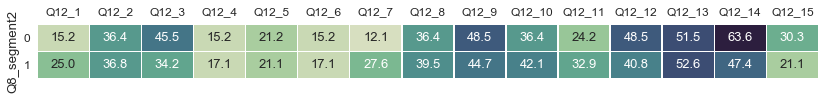

In [718]:
# Q12 proportion by segments
groupby_pct(Q12, segment= Q8_cluster2['Q8_segment2'], figsize= (14,1))

# 65% of segment 0 selected Q12_14
# 54% of segment 1 selected Q12_13

# Analysis by Graudation Year

In [719]:
# Create a dummy variable for class of 2020 (graduating class)
df['class_2020']= (df['class'] == '2020').astype(int)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (class_2020 = 0): 5.389, N: 36
mean of Q7 when (class_2020 = 1): 5.479, N: 73
p-value of the difference: 0.638


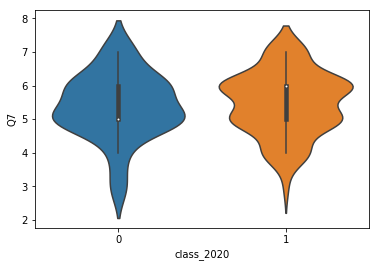

In [720]:
# T-test for 2020 vs. non-2020 on overall satisfaction
multi_ttest_1d(df, 'class_2020', 'Q7', alpha= 0.05, violinplot= True)

In [721]:
# T-test for 2020 vs. non-2020 on satisfaction (Q8)
Q8_clusters= transformed_variables_Q8.columns.values
df[Q8_clusters]= Q8_cluster2[Q8_clusters]
multi_ttest_2d(df, 'class_2020', Q8_clusters, alpha= 0.05, violinplot= None)

# No difference

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (class_2020 = 0): 0.074, N: 36
mean of Q8_factor1 when (class_2020 = 1): -0.037, N: 73
p-value of the difference: 0.589
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (class_2020 = 0): -0.221, N: 36
mean of Q8_factor2 when (class_2020 = 1): 0.109, N: 73
p-value of the difference: 0.107
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (class_2020 = 0): 0.216, N: 36
mean of Q8_factor3 when (class_2020 = 1): -0.107, N: 73
p-value of the difference: 0.115


In [722]:
# T-test for 2020 vs. non-2020 on importance (Q9)
multi_ttest_2d(df, 'class_2020', Q9.columns.values, alpha= 0.05, violinplot= None)

# No difference

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (class_2020 = 0): 5.056, N: 36
mean of Q9_1 when (class_2020 = 1): 4.753, N: 73
p-value of the difference: 0.354
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (class_2020 = 0): 4.889, N: 36
mean of Q9_2 when (class_2020 = 1): 4.877, N: 73
p-value of the difference: 0.969
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (class_2020 = 0): 5.250, N: 36
mean of Q9_3 when (class_2020 = 1): 5.110, N: 73
p-value of the difference: 0.653
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (class_2020 = 0): 4.583, N: 36
mean of Q9_4 when (class_2020 = 1): 4.795, N: 73
p-value of the difference: 0.498
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (class_2020 = 0): 4.917, N: 36
mean of Q9_5 when (class_2020 = 1): 4.644, N: 73
p-value of the difference: 0.371
In Q9_6, segments 0 vs. 1: no difference

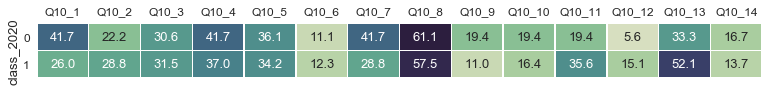

In [723]:
# Q10 proportion by class_2020
groupby_pct(Q10, segment= df['class_2020'], figsize= (13,1))

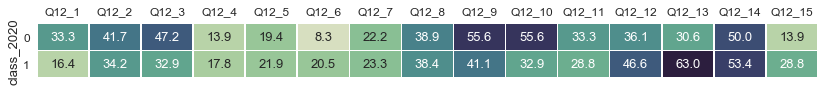

In [724]:
# Q12 proportion by class_2020
groupby_pct(Q12, segment= df['class_2020'], figsize= (14,1))

# SPMI Analysis

In [725]:
# Create a dummy variable to separate SPMI cohort
df['is_SPMI']= (df['immersion'] == 'SPMI').astype(int)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (is_SPMI = 0): 5.427, N: 82
mean of Q7 when (is_SPMI = 1): 5.519, N: 27
p-value of the difference: 0.662


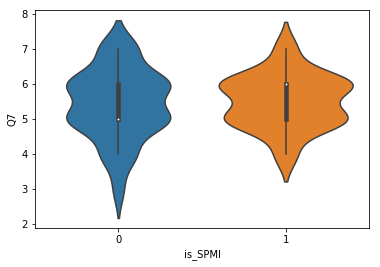

In [726]:
# T-test for SPMI vs. non-SPMI on overall satisfaction
multi_ttest_1d(df, 'is_SPMI', 'Q7', alpha= 0.05, violinplot= True)

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (is_SPMI = 0): 0.022, N: 82
mean of Q8_factor1 when (is_SPMI = 1): -0.066, N: 27
p-value of the difference: 0.696


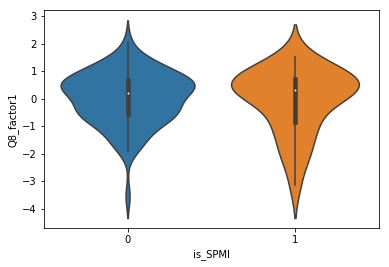

In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (is_SPMI = 0): 0.061, N: 82
mean of Q8_factor2 when (is_SPMI = 1): -0.184, N: 27
p-value of the difference: 0.273


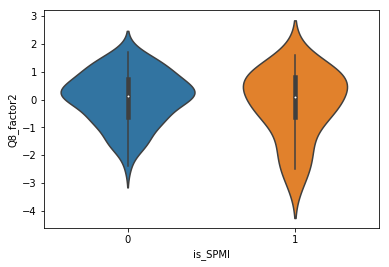

In Q8_factor3, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q8_factor3 when (is_SPMI = 0): -0.144, N: 82
mean of Q8_factor3 when (is_SPMI = 1): 0.436, N: 27
p-value of the difference: 0.009


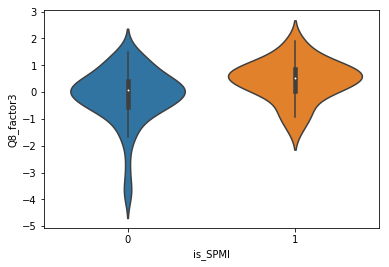

In [727]:
# T-test for SPMI vs. non-SPMI on satisfaction (Q8)
multi_ttest_2d(df, 'is_SPMI', Q8_clusters, alpha= 0.05, violinplot= True)

# Factor 3?

In [728]:
# T-test for SPMI vs. non-SPMI on importance (Q9)
multi_ttest_2d(df, 'is_SPMI', Q9.columns.values, alpha= 0.05, violinplot= None)

# No difference

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (is_SPMI = 0): 4.890, N: 82
mean of Q9_1 when (is_SPMI = 1): 4.741, N: 27
p-value of the difference: 0.674
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (is_SPMI = 0): 4.805, N: 82
mean of Q9_2 when (is_SPMI = 1): 5.111, N: 27
p-value of the difference: 0.368
In Q9_3, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q9_3 when (is_SPMI = 0): 4.988, N: 82
mean of Q9_3 when (is_SPMI = 1): 5.667, N: 27
p-value of the difference: 0.044
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (is_SPMI = 0): 4.744, N: 82
mean of Q9_4 when (is_SPMI = 1): 4.667, N: 27
p-value of the difference: 0.820
In Q9_5, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q9_5 when (is_SPMI = 0): 4.573, N: 82
mean of Q9_5 when (is_SPMI = 1): 5.222, N: 27
p-value of the difference: 0.049
In Q9_6, segments 0 vs. 1:

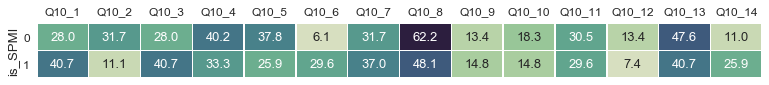

In [729]:
# Q10 proportion by is_SPMI
groupby_pct(Q10, segment= df['is_SPMI'], figsize= (13,1))

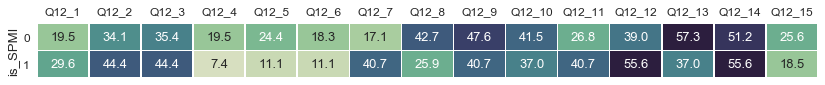

In [730]:
# Q12 proportion by is_SPMI
groupby_pct(Q12, segment= df['is_SPMI'], figsize= (14,1))

# SPMI Analysis by Graduation Year

In [731]:
# Create a subset of SPMI data
SPMI= df.loc[df['immersion'] == 'SPMI'].copy()

In Q7, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q7 when (class_2020 = 0): 5.250, N: 16
mean of Q7 when (class_2020 = 1): 5.909, N: 11
p-value of the difference: 0.022


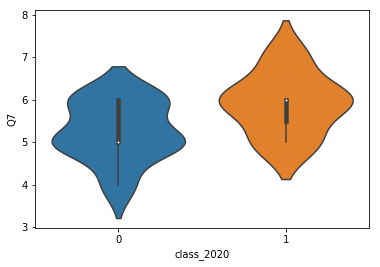

In [732]:
# T-test for SPMI class of 2020 vs. 2021 on overall satisfaction
multi_ttest_1d(SPMI, 'class_2020', 'Q7', alpha= 0.05, violinplot= True)

# Class of 2021 are less satisfied than class of 2020

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (class_2020 = 0): 0.010, N: 16
mean of Q8_factor1 when (class_2020 = 1): -0.177, N: 11
p-value of the difference: 0.688


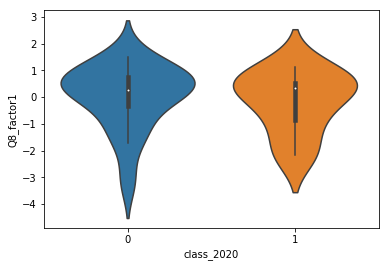

In Q8_factor2, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q8_factor2 when (class_2020 = 0): -0.754, N: 16
mean of Q8_factor2 when (class_2020 = 1): 0.644, N: 11
p-value of the difference: 0.002


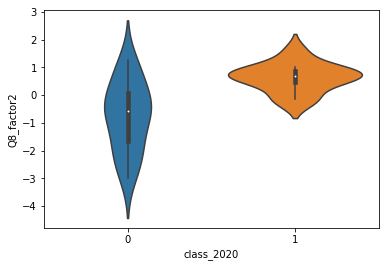

In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (class_2020 = 0): 0.356, N: 16
mean of Q8_factor3 when (class_2020 = 1): 0.553, N: 11
p-value of the difference: 0.513


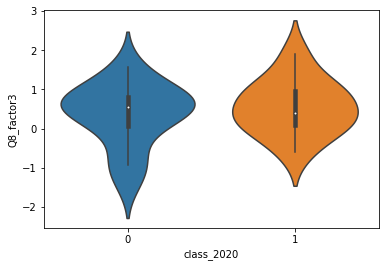

In [733]:
# T-test for SPMI class of 2020 vs. 2021 on satisfaction (Q8)
multi_ttest_2d(SPMI, 'class_2020', Q8_clusters, alpha= 0.05, violinplot= True)

# The differences in factor 2 are significant

In [734]:
# T-test for SPMI vs. non-SPMI on importance (Q9)
multi_ttest_2d(SPMI, 'class_2020', Q9.columns.values, alpha= 0.05, violinplot= None)

# The difference in Q9_6,7,11 (career networking) is significant

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (class_2020 = 0): 4.938, N: 16
mean of Q9_1 when (class_2020 = 1): 4.455, N: 11
p-value of the difference: 0.461
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (class_2020 = 0): 5.062, N: 16
mean of Q9_2 when (class_2020 = 1): 5.182, N: 11
p-value of the difference: 0.829
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (class_2020 = 0): 5.375, N: 16
mean of Q9_3 when (class_2020 = 1): 6.091, N: 11
p-value of the difference: 0.220
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (class_2020 = 0): 4.688, N: 16
mean of Q9_4 when (class_2020 = 1): 4.636, N: 11
p-value of the difference: 0.931
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (class_2020 = 0): 4.938, N: 16
mean of Q9_5 when (class_2020 = 1): 5.636, N: 11
p-value of the difference: 0.188
In Q9_6, segments 0 vs. 1: no difference

In [735]:
# Case summary for the variables with significant difference
SPMI[['Q7', 'Q9_6', 'Q9_7', 'Q9_11']].groupby(SPMI['class_2020']).agg(['mean', 'std', 'count']).round(3)

Q7                Q9_6                Q9_7              Q9_11  \
             mean    std count   mean    std count   mean    std count  mean   
class_2020                                                                     
0           5.250  0.683    16  4.438  1.548    16  5.875  1.025    16  3.75   
1           5.909  0.701    11  5.273  1.794    11  4.364  1.912    11  5.00   

                         
              std count  
class_2020               
0           1.438    16  
1           1.732    11

In [742]:
# Q10 proportion within SPMI by class_2020 
#groupby_pct(SPMI[Q10.columns.values], segment= SPMI['class_2020'], figsize= (13,1))

# Insternational Students Analysis

In [737]:
# Create a dummy variable to separate international cohort
df['is_intl']= (df['intl'] == 'international').astype(int)

In [738]:
# T-test for intl. vs. non-intl. on overall satisfaction
multi_ttest_1d(df, 'is_intl', 'Q7', alpha= 0.05, violinplot= None)

# No difference

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (is_intl = 0): 5.544, N: 68
mean of Q7 when (is_intl = 1): 5.293, N: 41
p-value of the difference: 0.176


In [739]:
# T-test for intl. vs. non-intl. on Q8 factors
Q8_cluster2['is_intl']= df['is_intl']
multi_ttest_2d(Q8_cluster2, 'is_intl', ['Q8_factor1', 'Q8_factor2', 'Q8_factor3'], alpha= 0.05, violinplot= None)

# No difference

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (is_intl = 0): -0.086, N: 68
mean of Q8_factor1 when (is_intl = 1): 0.143, N: 41
p-value of the difference: 0.250
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (is_intl = 0): 0.085, N: 68
mean of Q8_factor2 when (is_intl = 1): -0.141, N: 41
p-value of the difference: 0.257
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (is_intl = 0): -0.020, N: 68
mean of Q8_factor3 when (is_intl = 1): 0.032, N: 41
p-value of the difference: 0.795


In [740]:
# T-test for intl. vs. non-intl. on importance (Q9)
multi_ttest_2d(df, 'is_intl', Q9.columns.values, alpha= 0.05, violinplot= None)

# No difference

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (is_intl = 0): 4.971, N: 68
mean of Q9_1 when (is_intl = 1): 4.659, N: 41
p-value of the difference: 0.324
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (is_intl = 0): 4.794, N: 68
mean of Q9_2 when (is_intl = 1): 5.024, N: 41
p-value of the difference: 0.448
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (is_intl = 0): 5.191, N: 68
mean of Q9_3 when (is_intl = 1): 5.098, N: 41
p-value of the difference: 0.757
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (is_intl = 0): 4.632, N: 68
mean of Q9_4 when (is_intl = 1): 4.878, N: 41
p-value of the difference: 0.416
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (is_intl = 0): 4.779, N: 68
mean of Q9_5 when (is_intl = 1): 4.659, N: 41
p-value of the difference: 0.683
In Q9_6, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q